In [43]:
import json
import logging
from pathlib import Path
from copy import deepcopy

import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import pandas as pd


# Configure logging for better debug information
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# CONFIGURATION

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Paths (customize these)
COCO_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json")
IMAGES_DIR       = Path("../data/rotation/batches/rotation_20250721_01/images/default/")
PRED_JSON        = Path("../data/rotation/batches/rotation_20250721_01/instances_predicted.json")
ATTR_JSON        = Path("../data/rotation/batches/rotation_20250721_01/instances_updated.json") 
CHECKPOINT_PATH  = Path("checkpoints/best_model.pth")

# Class labels in the exact order your model was trained on
CLASS_NAMES = [0, 90, 180, 270]

In [18]:


# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing for the classifier
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [56]:
def load_coco(path: Path) -> dict:
    logger.info(f"Loading COCO from {path}")
    return json.loads(path.read_text(encoding="utf-8"))

def save_coco(coco: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    logger.info(f"Writing COCO to {path}")
    path.write_text(json.dumps(coco, ensure_ascii=False, indent=2), encoding="utf-8")

In [57]:
def load_model(ckpt_path: Path) -> nn.Module:
    logger.info(f"Loading model from {ckpt_path}")
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    ckpt = torch.load(str(ckpt_path), map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    return model.to(DEVICE).eval()


In [58]:
def crop_box(img: np.ndarray, x, y, w, h):
    x1, y1 = max(0,int(round(x))), max(0,int(round(y)))
    x2 = min(img.shape[1], int(round(x+w)))
    y2 = min(img.shape[0], int(round(y+h)))
    return img[y1:y2, x1:x2]

def predict_angle(model, patch: np.ndarray) -> float:
    rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    t = TRANSFORM(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(t)
        idx = torch.argmax(logits, dim=1).item()
    return float(CLASS_NAMES[idx])

def extract_current_rotation(ann: dict) -> float:
    bb = ann.get("bbox", [])
    if len(bb) == 5:
        return float(bb[4])
    attrs = ann.get("attributes")
    if isinstance(attrs, dict) and "rotation" in attrs:
        return float(attrs["rotation"])
    return 0.0

def debug_annotation(ann_id, image_id, fname, orig_rot, pred_rot, bbox, full_img):
    x,y,w,h = bbox
    patch = crop_box(full_img, x, y, w, h)
    # convert BGR->RGB for display
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    full_rgb  = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    print(f"\n▶ Annotation {ann_id} on image {image_id} ({fname})")
    print(f"  • Original rot: {orig_rot}°   Predicted rot: {pred_rot}°")
    print(f"  • BBox (x,y,w,h): {bbox}")

    # display side by side
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
    ax1.imshow(patch_rgb); ax1.axis("off")
    ax1.set_title(f"Crop {patch.shape[1]}×{patch.shape[0]}")
    ax2.imshow(full_rgb); ax2.axis("off")
    # overlay rotated rectangle
    cx, cy = x + w/2, y + h/2
    rect = Rectangle((cx-w/2, cy-h/2), w, h, fill=False, edgecolor="red", linewidth=1)
    t = Affine2D().rotate_deg_around(cx, cy, pred_rot) + ax2.transData
    rect.set_transform(t)
    ax2.add_patch(rect)
    ax2.scatter([x],[y], color="blue", s=5)  # top-left anchor
    ax2.scatter([cx],[cy], color="lime", s=5)  # center
    ax2.set_title("Full Image w/ box")
    plt.show()

In [44]:
def extract_current_rotation(ann: dict) -> float:
    bbox = ann.get("bbox", [])
    if len(bbox) == 5:
        return float(bbox[4])
    attrs = ann.get("attributes")
    if isinstance(attrs, dict) and "rotation" in attrs:
        return float(attrs["rotation"])
    return 0.0

In [59]:
def update_rotations(target_image_id: int = 1, debug: bool = False):
    coco      = load_coco(COCO_JSON)
    coco_attr = deepcopy(coco)
    model     = load_model(CHECKPOINT_PATH)

    images = {img["id"]: img for img in coco["images"]}
    cache  = {}
    records = []

    for ann, ann_attr in zip(coco["annotations"], coco_attr["annotations"]):
        if ann["image_id"] != target_image_id:
            continue

        x,y,w,h = ann["bbox"][:4]
        cur_rot  = extract_current_rotation(ann)
        # only correct ±10° of base angles
        if not any(abs(cur_rot - base) <= 10 for base in CLASS_NAMES):
            continue

        info  = images[ann["image_id"]]
        fname = info["file_name"]
        if fname not in cache:
            img = cv2.imread(str(IMAGES_DIR / fname))
            if img is None:
                logger.error(f"Cannot load {fname}")
                continue
            cache[fname] = img
        img_full = cache[fname]

        pred = predict_angle(model, img_full[y:int(y+h), x:int(x+w)] if False else crop_box(img_full, x, y, w, h))
        records.append({
            "ann_id":    ann["id"],
            "img_id":    ann["image_id"],
            "file_name": fname,
            "bbox":      [x,y,w,h],
            "orig_rot":  cur_rot,
            "pred_rot":  pred
        })

        if pred != cur_rot:
            cx,cy = x+w/2, y+h/2
            ann["bbox"] = [cx, cy, w, h, pred]
            ann.setdefault("attributes", {})["rotation"] = pred
            ann_attr.setdefault("attributes", {})["rotation"] = pred

        if debug:
            debug_annotation(ann["id"], ann["image_id"], fname, cur_rot, pred, [x,y,w,h], img_full)

    # save both versions
    save_coco(coco,      PRED_JSON)
    save_coco(coco_attr, ATTR_JSON)

    # final summary
    df_debug = pd.DataFrame(records)
    print("\n=== Summary of processed annotations ===")
    display(df_debug)  # if in Jupyter; otherwise: print(df_debug.to_string(index=False))


INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json
INFO:__main__:Loading model from checkpoints/best_model.pth



▶ Annotation 1 on image 1 (7435.png)
  • Original rot: 269.96°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1201.64, 420.42, 42.0, 31.28]


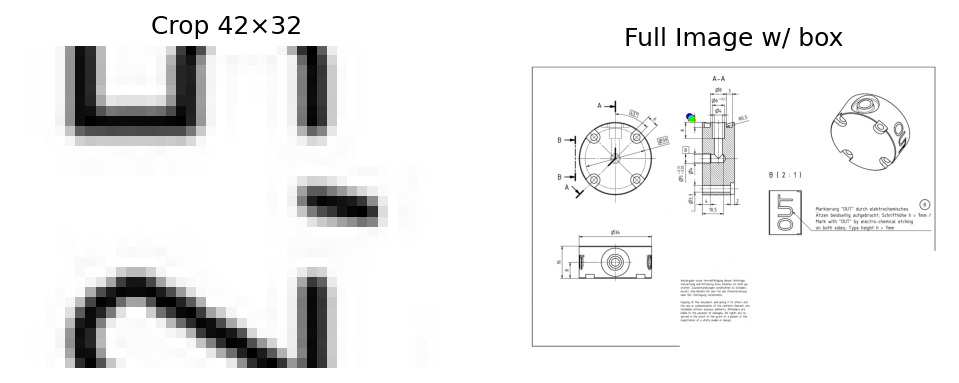


▶ Annotation 2 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1323.84, 1027.8, 16.96, 26.9]


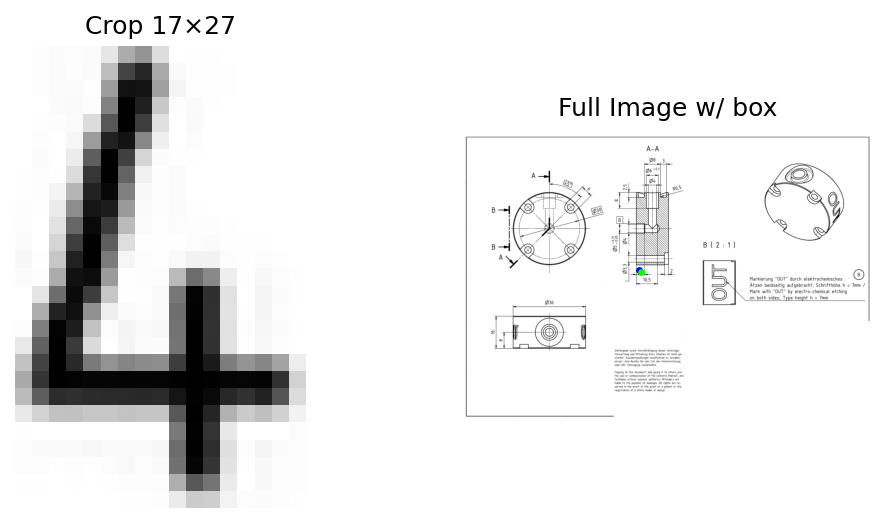


▶ Annotation 3 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1492.59, 230.52, 13.7, 26.5]


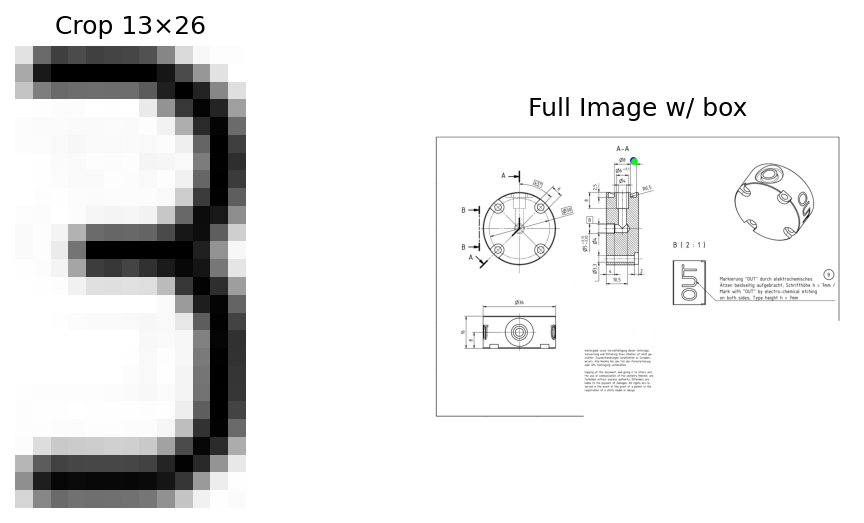


▶ Annotation 4 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [2124.76, 1083.27, 665.95, 34.72]


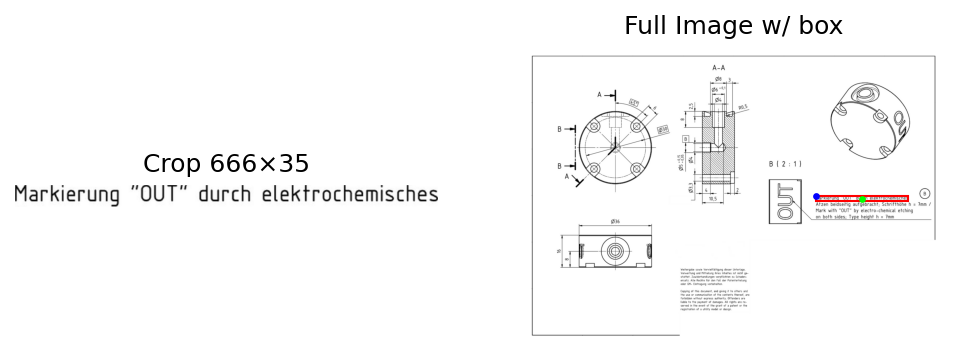


▶ Annotation 5 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1353.25, 1089.4, 53.35, 31.9]


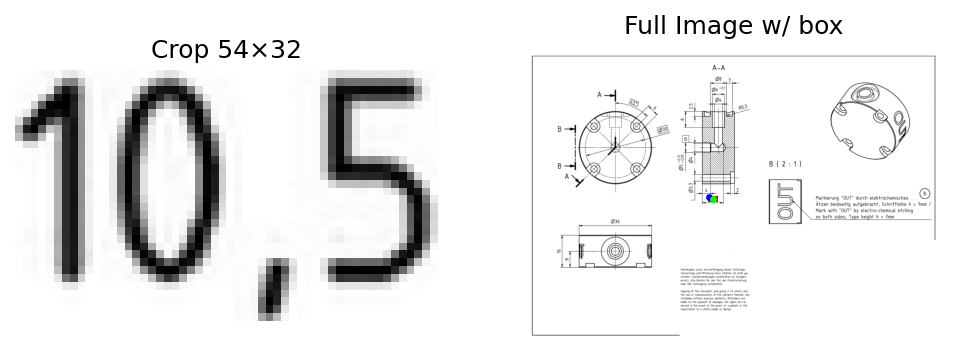


▶ Annotation 7 on image 1 (7435.png)
  • Original rot: 270.7°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1185.02, 1006.46, 69.35, 37.86]


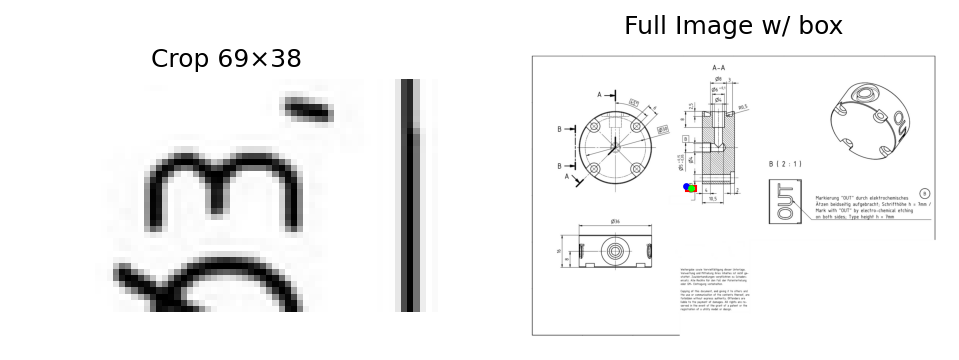


▶ Annotation 9 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1550.7, 1026.7, 14.1, 26.5]


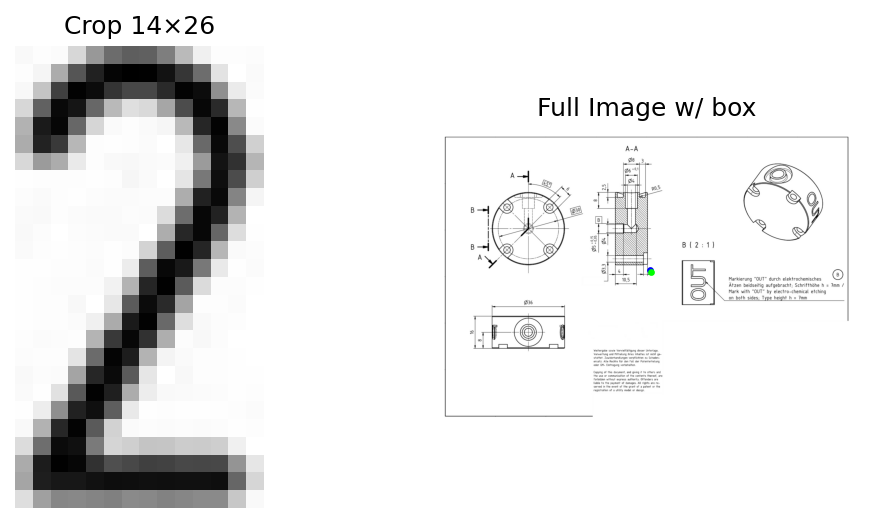


▶ Annotation 10 on image 1 (7435.png)
  • Original rot: 270.0°   Predicted rot: 270.0°
  • BBox (x,y,w,h): [316.5, 1528.5, 14.1, 25.7]


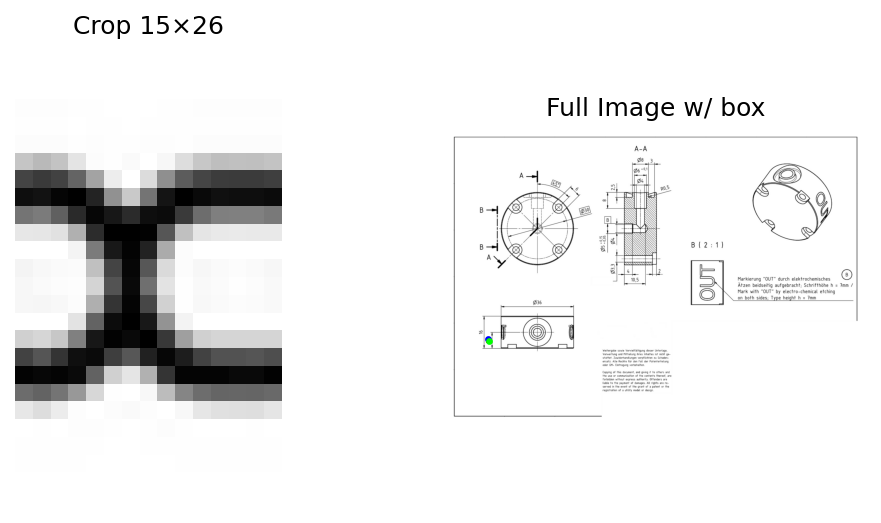


▶ Annotation 11 on image 1 (7435.png)
  • Original rot: 270.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [252.5, 1470.1, 27.0, 26.4]


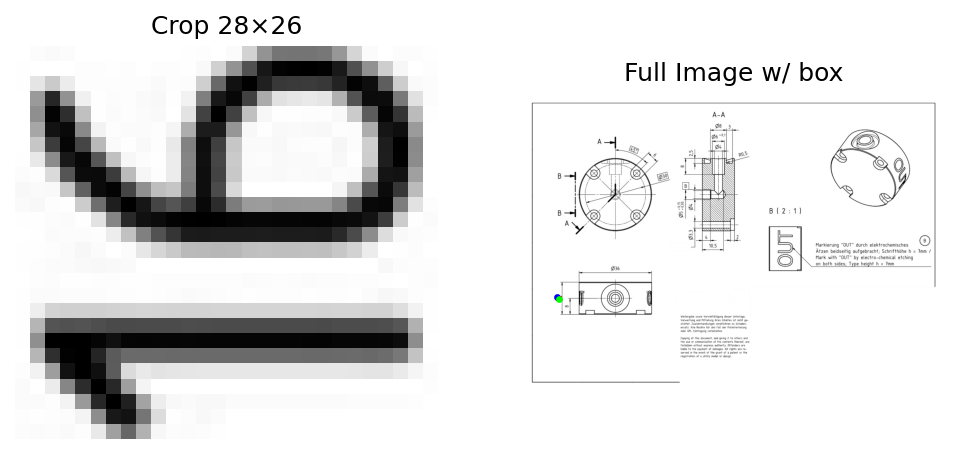


▶ Annotation 12 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.99, 1840.63, 476.8, 20.54]


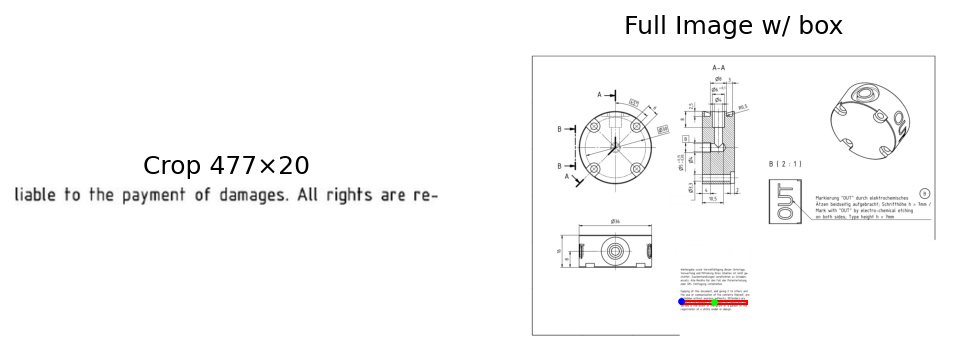


▶ Annotation 13 on image 1 (7435.png)
  • Original rot: 0.03°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1377.67, 136.14, 89.43, 39.36]


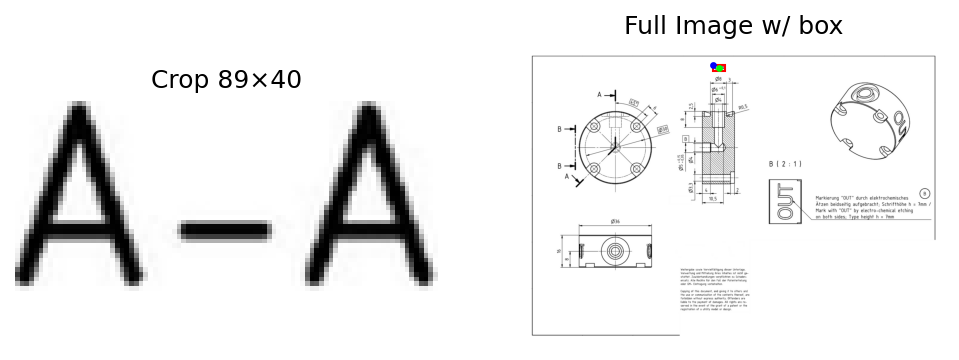


▶ Annotation 14 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [2902.9, 1053.04, 17.1, 27.86]


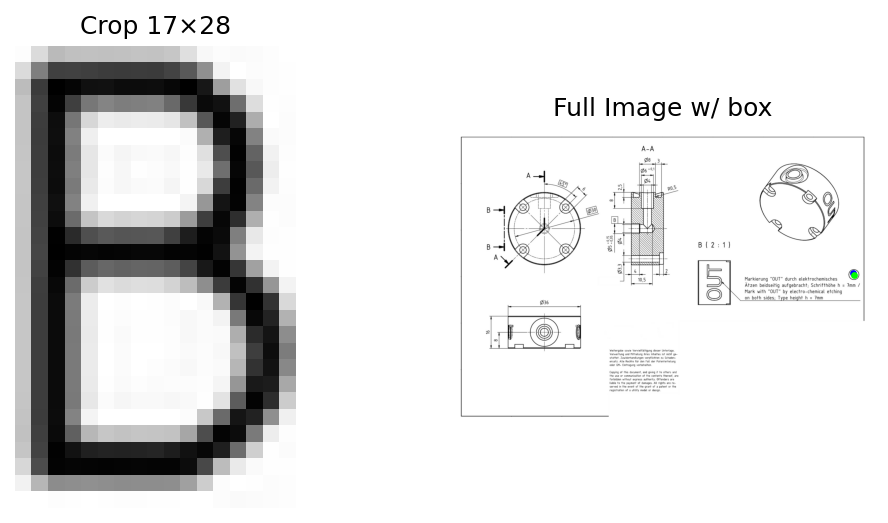


▶ Annotation 16 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [259.2, 846.98, 24.9, 40.02]


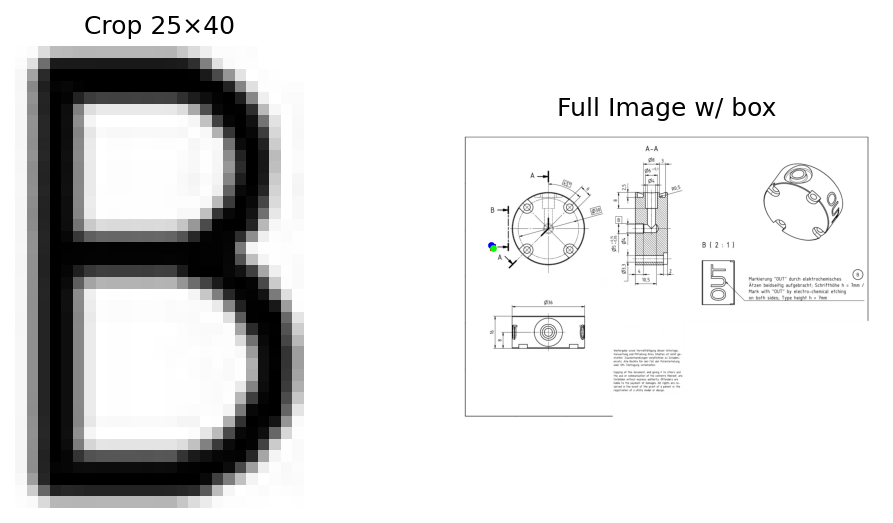


▶ Annotation 17 on image 1 (7435.png)
  • Original rot: 1.66°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [310.96, 920.32, 28.12, 39.8]


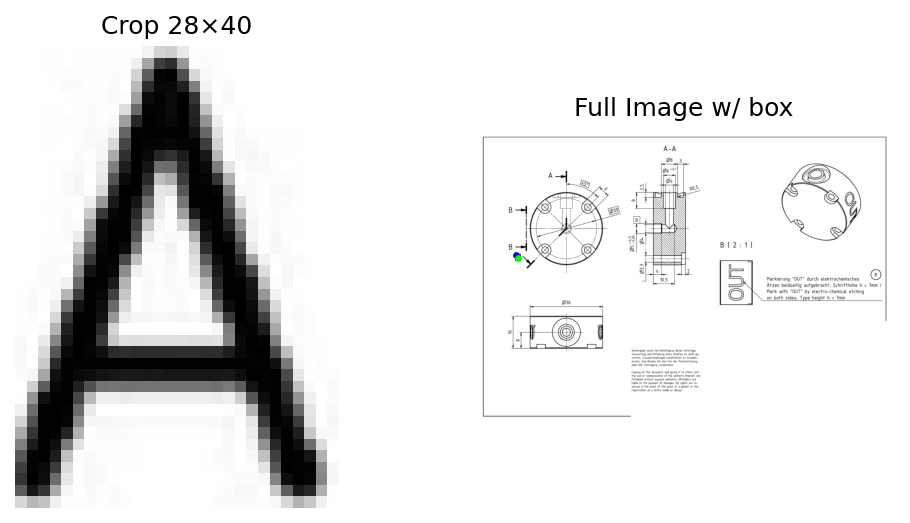


▶ Annotation 18 on image 1 (7435.png)
  • Original rot: 0.1°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [259.2, 580.22, 24.5, 39.78]


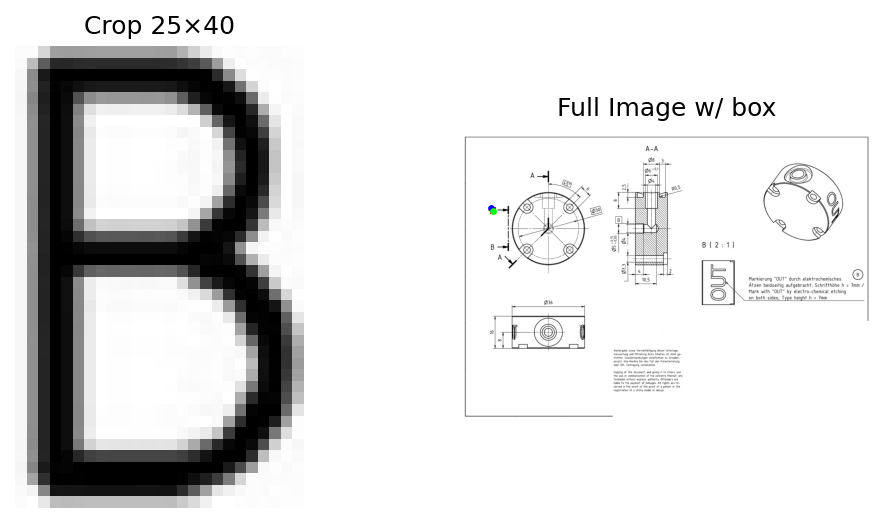


▶ Annotation 19 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.5, 1762.6, 483.74, 20.7]


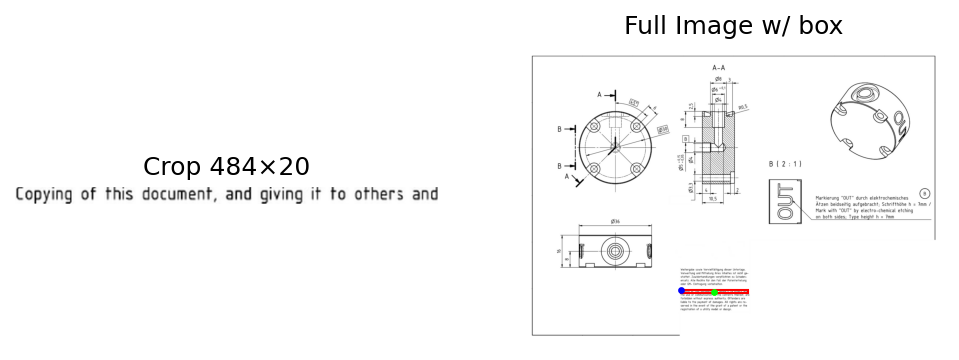


▶ Annotation 20 on image 1 (7435.png)
  • Original rot: 0.9°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1396.67, 370.63, 45.35, 37.77]


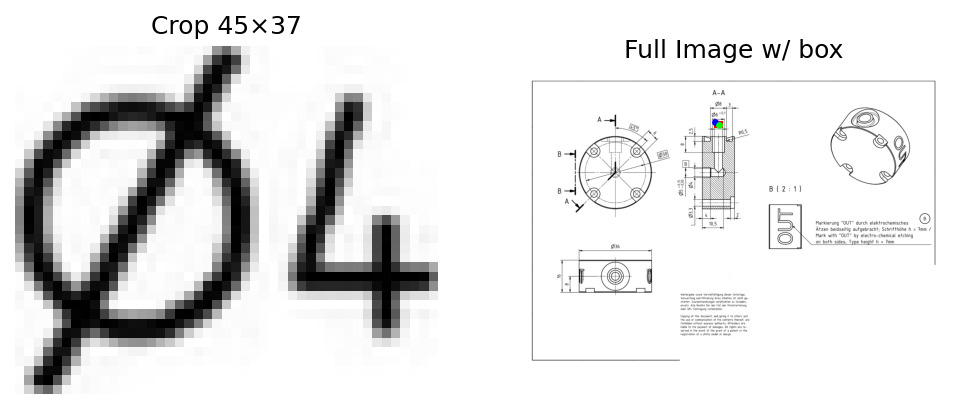


▶ Annotation 21 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1147.56, 1815.12, 464.38, 19.99]


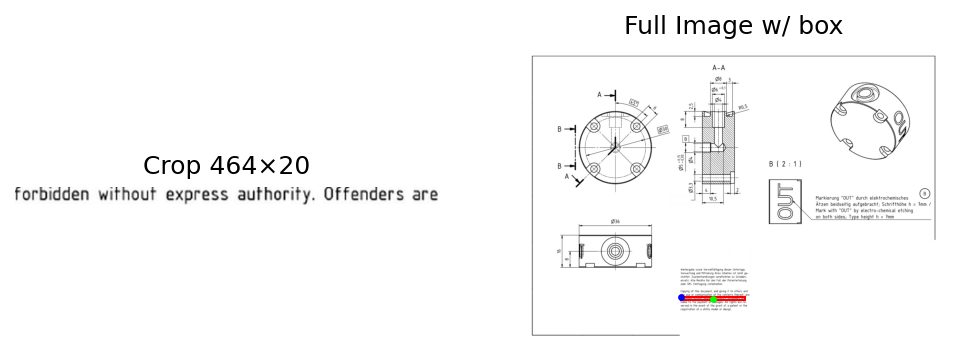


▶ Annotation 22 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.58, 1867.12, 480.37, 19.4]


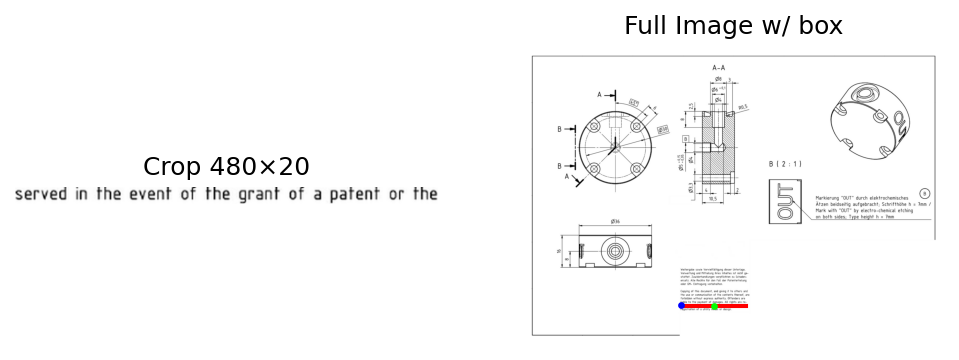


▶ Annotation 23 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.51, 1893.17, 367.14, 19.87]


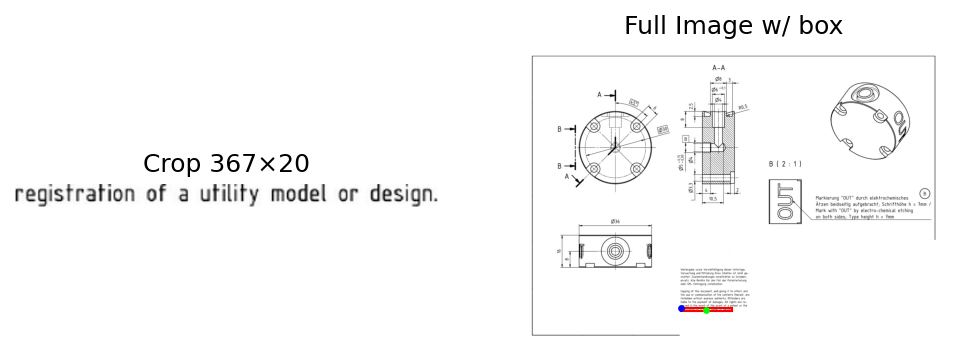


▶ Annotation 24 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [2124.94, 1120.94, 830.46, 42.96]


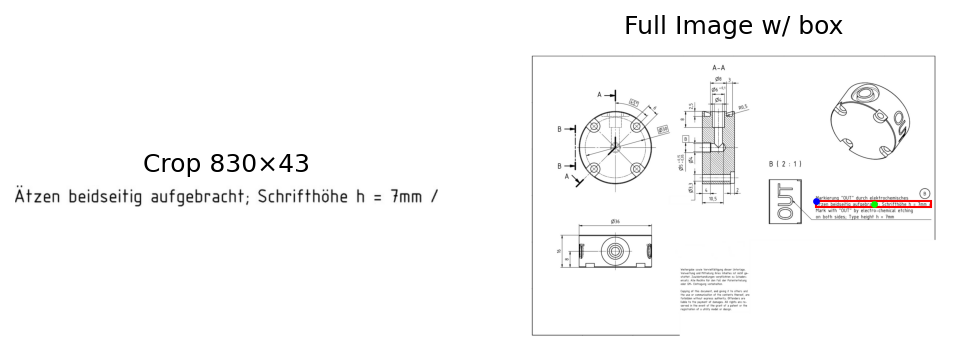


▶ Annotation 25 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1788.99, 828.0, 226.91, 46.1]


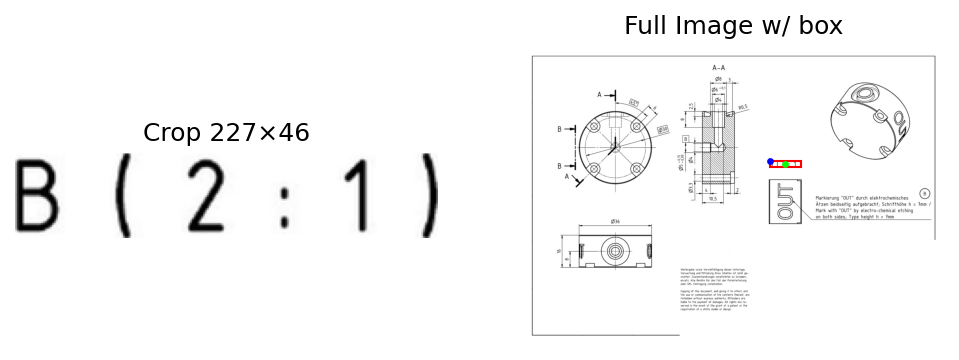


▶ Annotation 26 on image 1 (7435.png)
  • Original rot: 270.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1771.04, 1069.6, 262.72, 108.61]


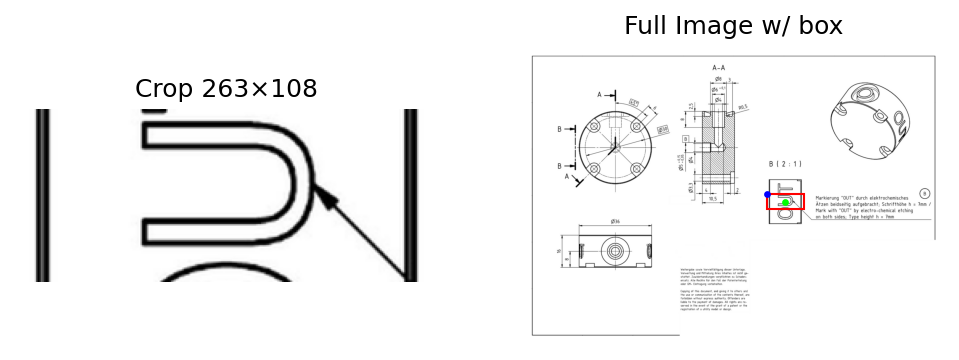


▶ Annotation 27 on image 1 (7435.png)
  • Original rot: 270.0°   Predicted rot: 270.0°
  • BBox (x,y,w,h): [1151.67, 517.81, 14.02, 25.39]


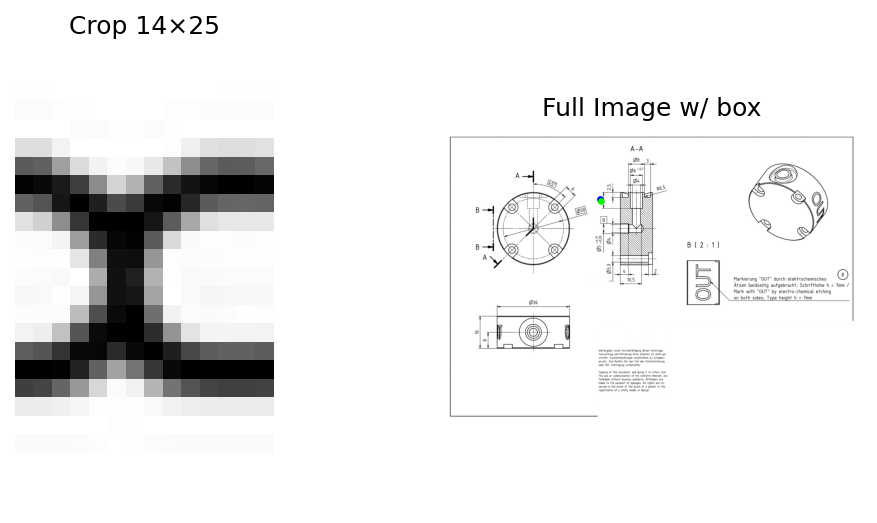


▶ Annotation 28 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1123.44, 788.4, 23.39, 55.52]


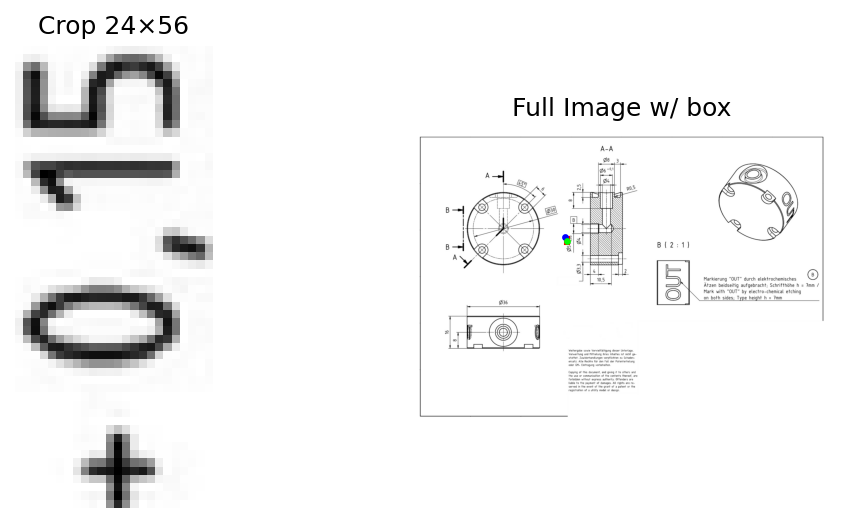


▶ Annotation 29 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1397.94, 219.07, 42.63, 38.16]


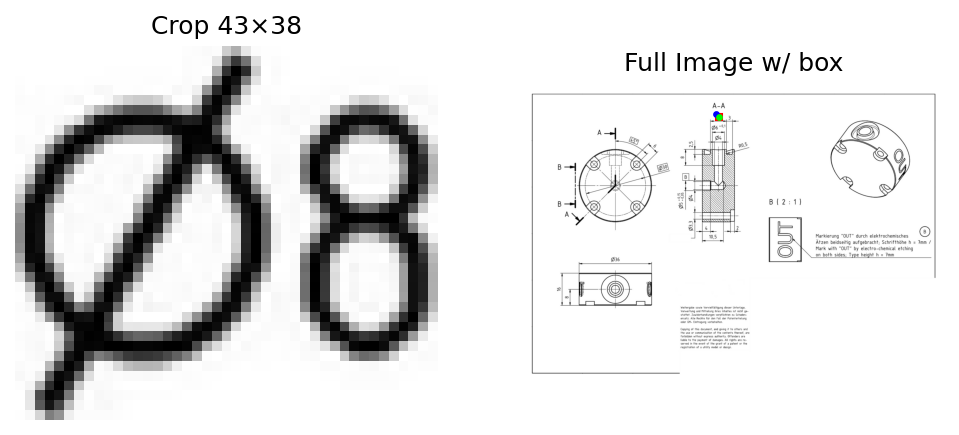


▶ Annotation 30 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [644.1, 1248.52, 60.9, 37.78]


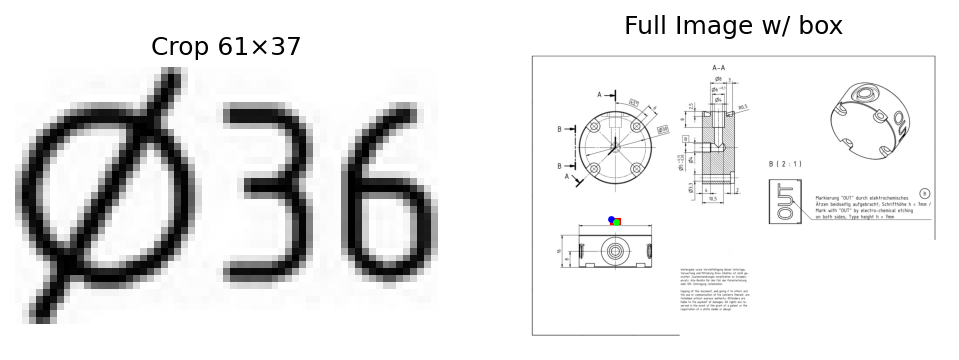


▶ Annotation 31 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1371.3, 297.31, 43.36, 37.59]


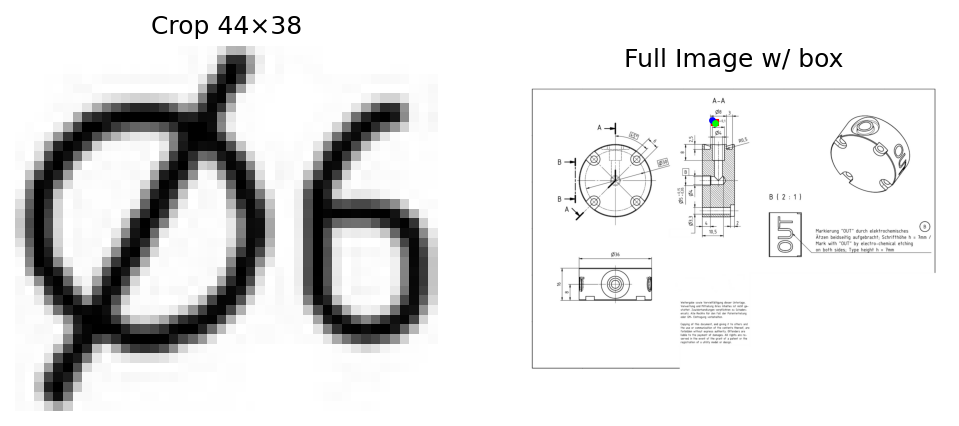


▶ Annotation 32 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1425.76, 293.14, 42.94, 22.96]


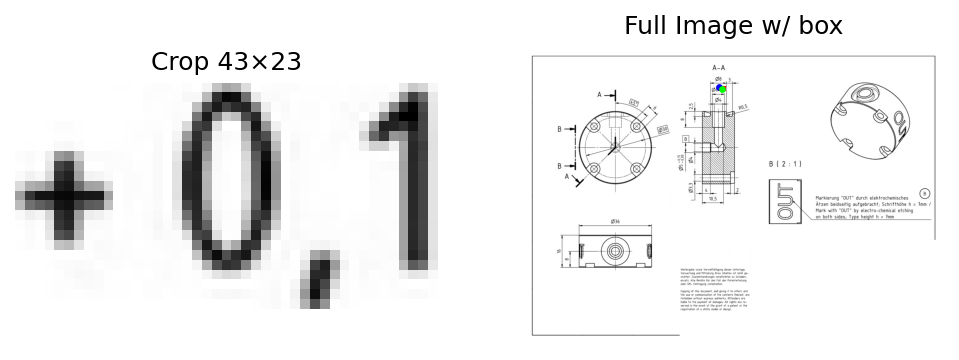


▶ Annotation 34 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1175.0, 659.3, 17.0, 27.1]


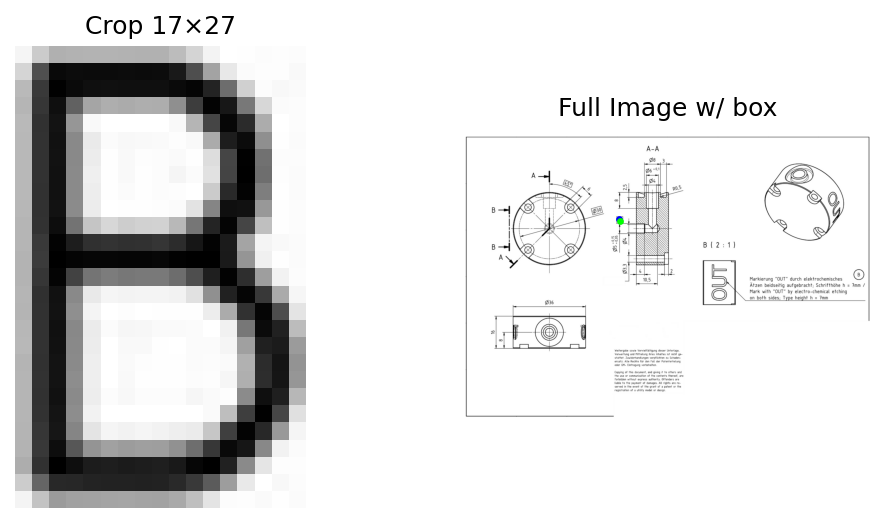


▶ Annotation 36 on image 1 (7435.png)
  • Original rot: 270.0°   Predicted rot: 180.0°
  • BBox (x,y,w,h): [1196.98, 803.96, 45.7, 38.4]


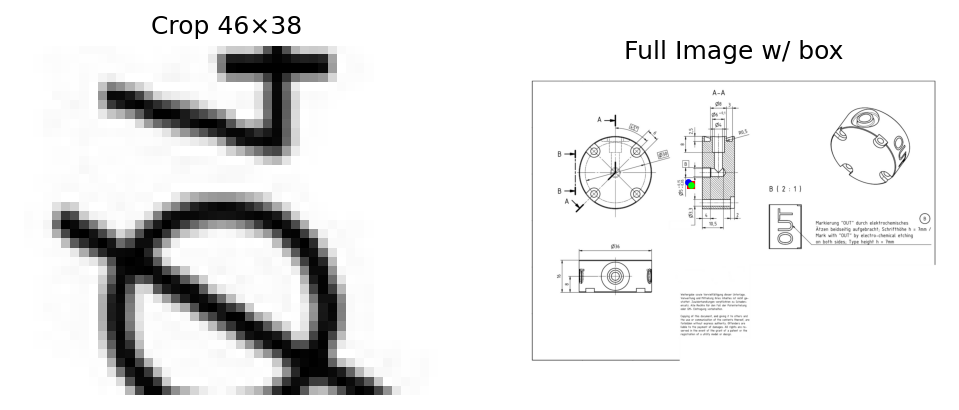


▶ Annotation 37 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1148.95, 784.76, 23.09, 59.46]


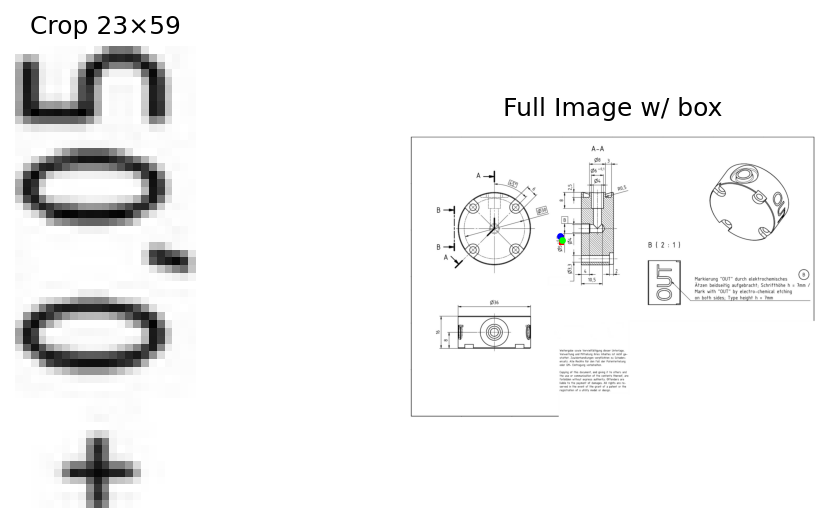


▶ Annotation 38 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1129.98, 857.13, 37.42, 42.67]


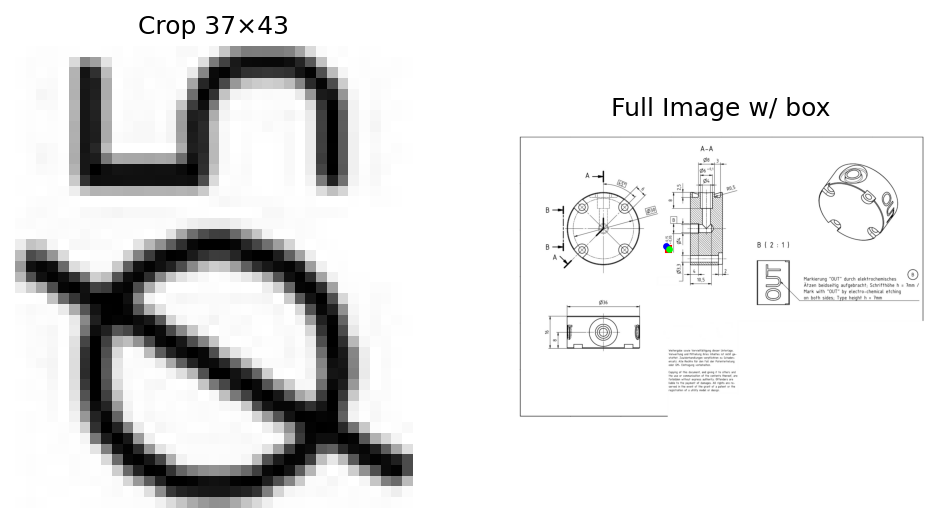


▶ Annotation 39 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [2124.63, 1174.33, 699.61, 33.97]


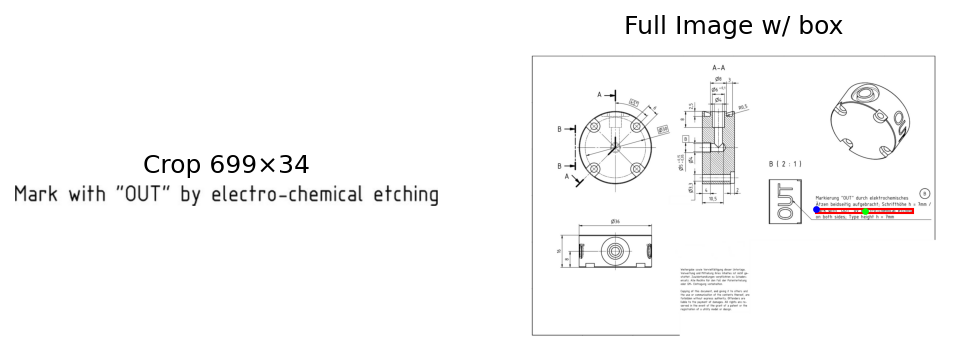


▶ Annotation 40 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [2124.55, 1219.91, 562.85, 34.04]


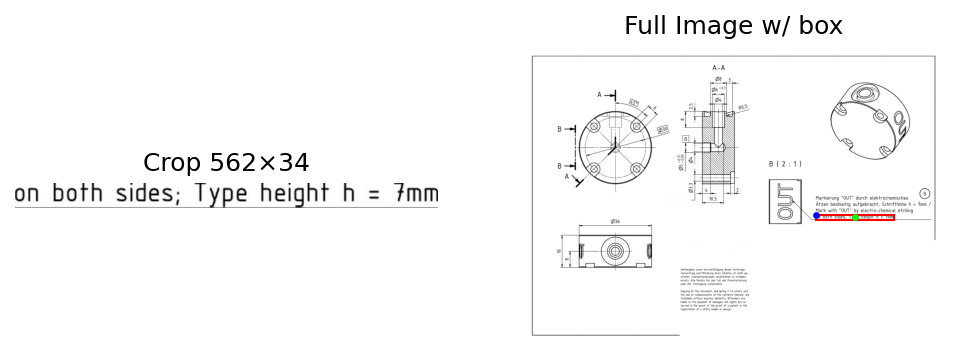


▶ Annotation 41 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.68, 1606.7, 466.62, 20.38]


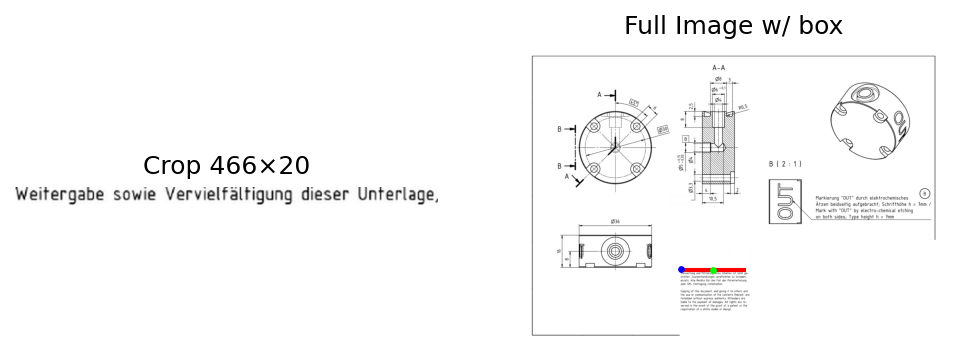


▶ Annotation 42 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1147.13, 1632.73, 489.31, 20.62]


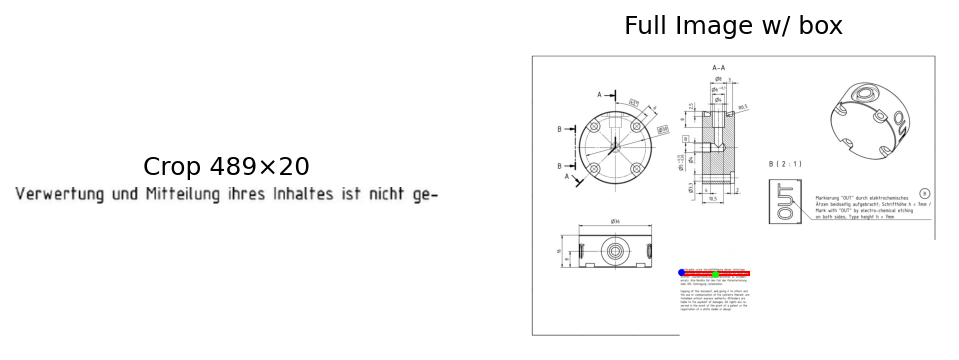


▶ Annotation 43 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.77, 1659.01, 477.17, 20.09]


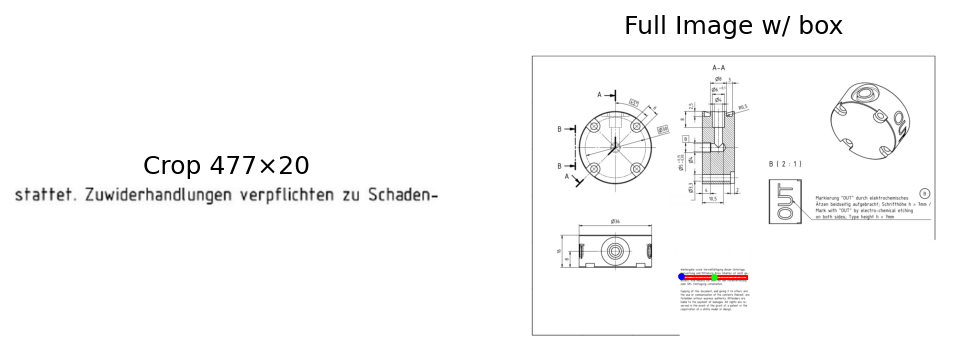


▶ Annotation 44 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1147.57, 1685.47, 473.98, 19.83]


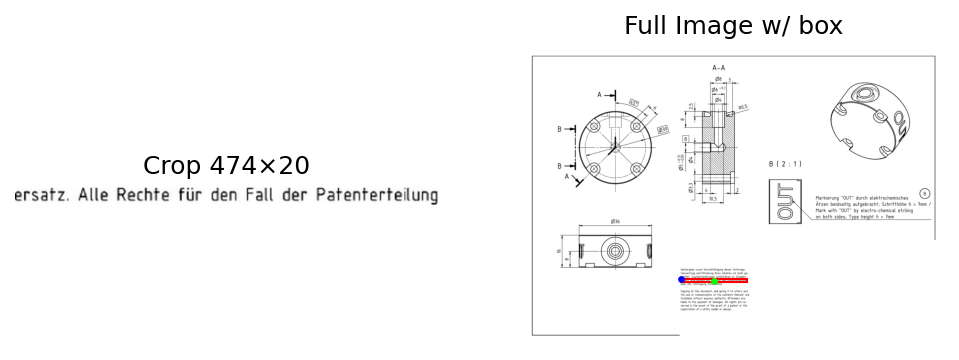


▶ Annotation 45 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1146.75, 1711.43, 302.85, 19.46]


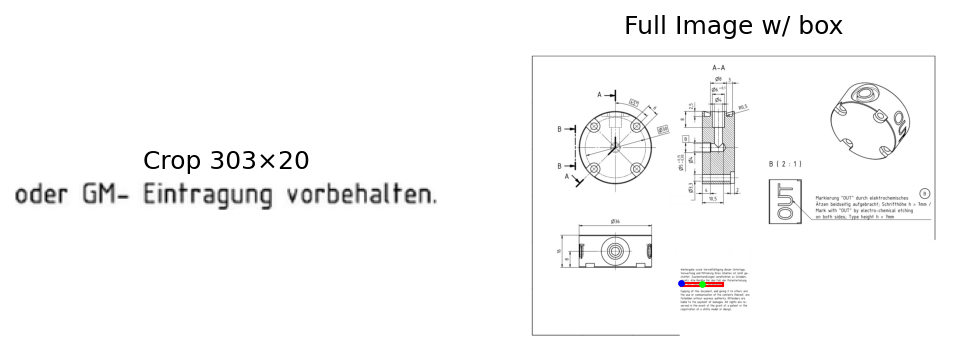


▶ Annotation 46 on image 1 (7435.png)
  • Original rot: 0.0°   Predicted rot: 0.0°
  • BBox (x,y,w,h): [1147.54, 1788.73, 496.15, 18.68]


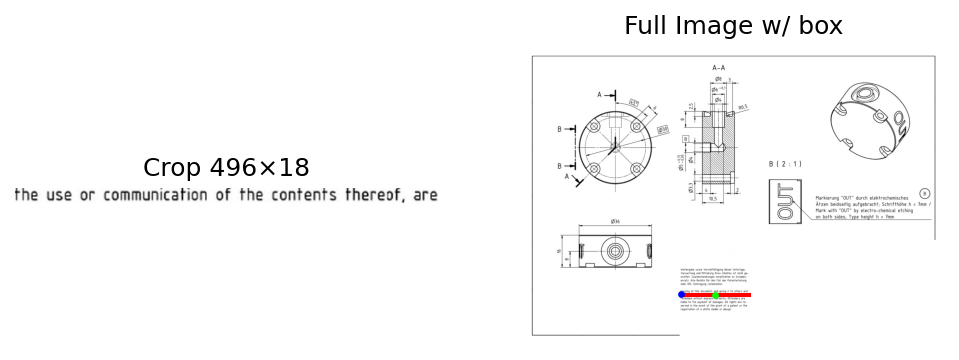

INFO:__main__:Writing COCO to ../data/rotation/batches/rotation_20250721_01/instances_predicted.json
INFO:__main__:Writing COCO to ../data/rotation/batches/rotation_20250721_01/instances_updated.json



=== Summary of processed annotations ===


,ann_id,img_id,file_name,bbox,orig_rot,pred_rot
0,1,1,7435.png,"[1201.64, 420.42, 42.0, 31.28]",269.96,0.0
1,2,1,7435.png,"[1323.84, 1027.8, 16.96, 26.9]",0.00,0.0
2,3,1,7435.png,"[1492.59, 230.52, 13.7, 26.5]",0.00,0.0
3,4,1,7435.png,"[2124.76, 1083.27, 665.95, 34.72]",0.00,0.0
4,5,1,7435.png,"[1353.25, 1089.4, 53.35, 31.9]",0.00,0.0
5,7,1,7435.png,"[1185.02, 1006.46, 69.35, 37.86]",270.70,0.0
6,9,1,7435.png,"[1550.7, 1026.7, 14.1, 26.5]",0.00,0.0
7,10,1,7435.png,"[316.5, 1528.5, 14.1, 25.7]",270.00,270.0
8,11,1,7435.png,"[252.5, 1470.1, 27.0, 26.4]",270.00,0.0
9,12,1,7435.png,"[1146.99, 1840.63, 476.8, 20.54]",0.00,0.0


In [60]:

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    # run on image_id=1 with debug turned on
    update_rotations(target_image_id=1, debug=True)

In [52]:
df_img.head()


,id,width,height,file_name,license,flickr_url,coco_url,date_captured
0,1,3057,2160,7435.png,0,,,0
1,2,3054,2160,7443.png,0,,,0
2,3,2160,3054,7445.png,0,,,0
3,4,2160,3055,7451.png,0,,,0
4,5,3338,2160,7459.png,0,,,0


In [51]:
df_ann.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,rotation
0,1,1,9,[],1313.760,"[1222.64, 436.06, 42.0, 31.28]",0,"{'occluded': False, 'rotation': 0.0}",0.0
1,2,1,9,[],456.224,"[1323.84, 1027.8, 16.96, 26.9]",0,"{'occluded': False, 'rotation': 0.0}",0.0
2,3,1,9,[],363.050,"[1492.59, 230.52, 13.7, 26.5]",0,"{'occluded': False, 'rotation': 0.0}",0.0
3,4,1,9,[],23121.784,"[2124.76, 1083.27, 665.95, 34.72]",0,"{'occluded': False, 'rotation': 0.0}",0.0
4,5,1,9,[],1701.865,"[1353.25, 1089.4, 53.35, 31.9]",0,"{'occluded': False, 'rotation': 0.0}",0.0


INFO:__main__:Loading COCO annotations from ../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json
INFO:__main__:Loading model from checkpoints/best_model.pth
INFO:__main__:Ann 1: 269.96° → 0.0°
INFO:__main__:Ann 7: 270.7° → 0.0°
INFO:__main__:Ann 11: 270.0° → 0.0°
INFO:__main__:Ann 13: 0.03° → 0.0°
INFO:__main__:Ann 17: 1.66° → 0.0°
INFO:__main__:Ann 18: 0.1° → 0.0°
INFO:__main__:Ann 20: 0.9° → 0.0°
INFO:__main__:Ann 26: 270.0° → 0.0°
INFO:__main__:Ann 36: 270.0° → 180.0°
INFO:__main__:Writing updated COCO to ../data/rotation/batches/rotation_20250721_01/instances_predicted.json
INFO:__main__:Writing updated COCO to ../data/rotation/batches/rotation_20250721_01/instances_updated.json
INFO:__main__:Loading COCO annotations from ../data/rotation/batches/rotation_20250721_01/instances_predicted.json


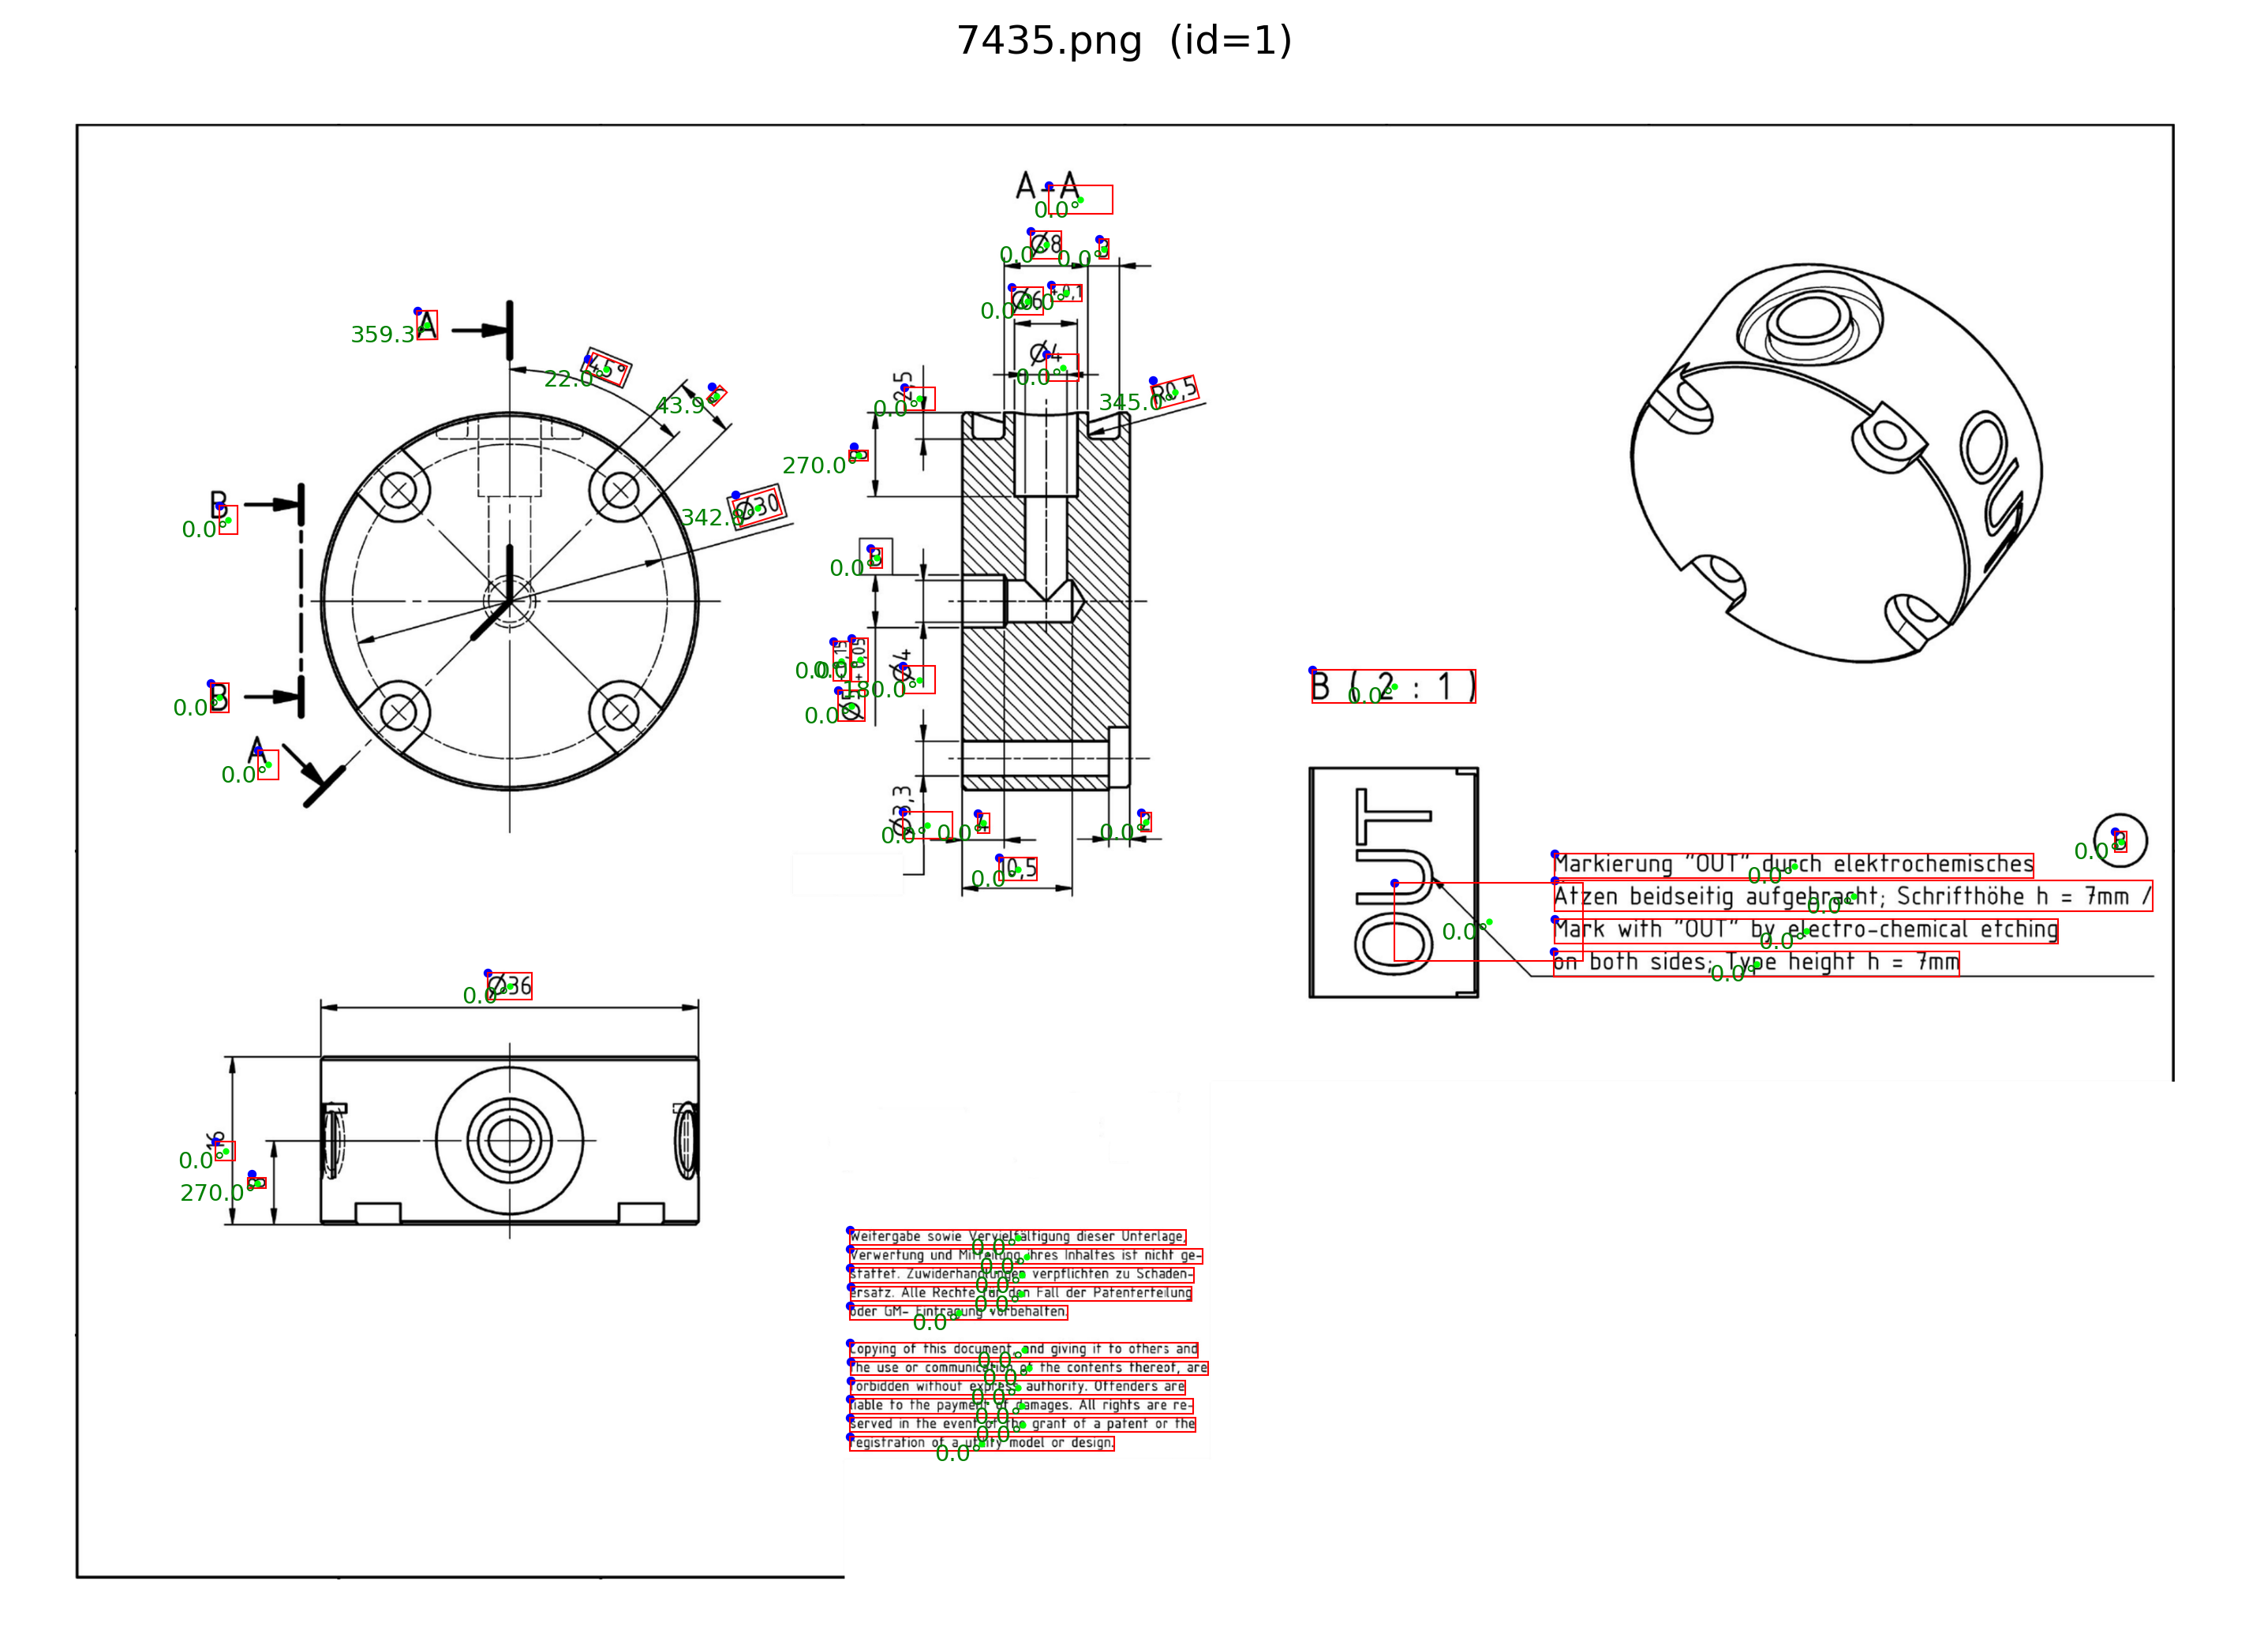

In [55]:
if __name__ == "__main__":
    # 1) run correction for a single image
    update_rotations(target_image_id=1)

    # 2) reload into DataFrame for visualization
    coco = load_coco(PRED_JSON)
    df_img = pd.DataFrame(coco["images"])
    df_ann = pd.DataFrame(coco["annotations"])

    # robustly extract bbox & rotation columns
    df_ann["rotation"] = df_ann.apply(lambda r: extract_current_rotation(r), axis=1)
    df_ann["bbox"] = df_ann.apply(lambda r: r["bbox"][:4], axis=1)

    # pick the image with id=1
    row = df_img[df_img["id"] == 1].iloc[0]
    show_image_with_annotations(row_img=row,
                                df_all=df_ann,
                                images_dir=IMAGES_DIR)